In [1]:
## import libraries and initialize spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, desc, approx_count_distinct, countDistinct,log, sqrt
from pyspark.sql import functions as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import plotly.figure_factory as ff
import plotly.offline as pyo

In [2]:
#initialize spark session
spark = SparkSession.builder \
    .appName("Data Exploration with PySpark") \
    .getOrCreate()

In [3]:
##Load Data
data_train = "/content/train.csv"
data_testA = "/content/testA.csv"

data_train = spark.read.csv(data_train, header=True, inferSchema=True)
data_testA = spark.read.csv(data_testA, header=True, inferSchema=True)

In [4]:
## Data Preprocessing

#check training dataset structure
data_train.printSchema()
data_train.show(5)

#check the size
print("Train data shape:",(data_train.count(),len(data_train.columns)))
print("TestA data shape:",(data_testA.count(),len(data_testA.columns)))

data_train.describe().show()


root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- subGrade: string (nullable = true)
 |-- employmentTitle: double (nullable = true)
 |-- employmentLength: string (nullable = true)
 |-- homeOwnership: integer (nullable = true)
 |-- annualIncome: double (nullable = true)
 |-- verificationStatus: integer (nullable = true)
 |-- issueDate: date (nullable = true)
 |-- isDefault: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- postCode: double (nullable = true)
 |-- regionCode: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinquency_2years: double (nullable = true)
 |-- ficoRangeLow: double (nullable = true)
 |-- ficoRangeHigh: double (nullable = true)
 |-- openAcc: double (nullable = true)
 |-- pubRec: double (nullable = true)
 |-- pubRecBankruptcies: dou

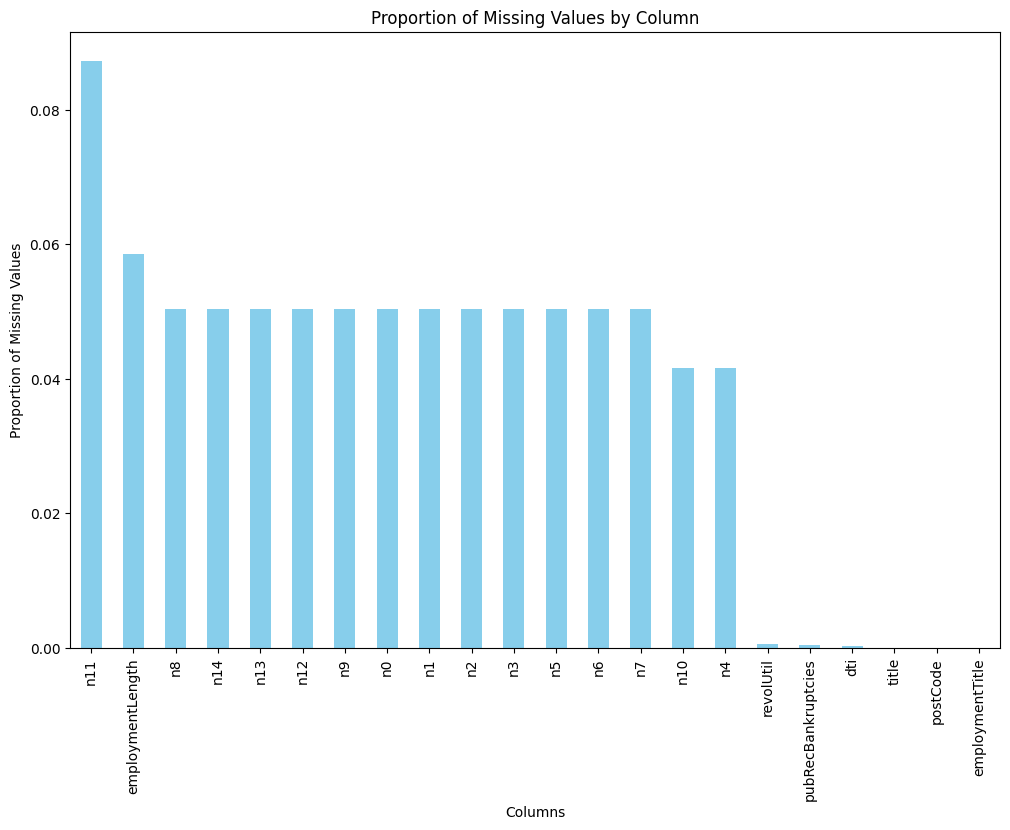

In [5]:
# visualize the NAN
# caclulate the missing ration
def calculate_missing_ratio(df):
    total_count = df.count()
    missing_ratio = df.select([((count(when(col(c).isNull(), c)) / total_count).alias(c)) for c in df.columns])
    return missing_ratio

# get the proportion of missing values
missing_ratio_df = calculate_missing_ratio(data_train)

# transform into pandas dataframe
missing_ratio_pd = missing_ratio_df.toPandas()
missing_ratio_pd = missing_ratio_pd.transpose()
missing_ratio_pd.columns = ['missing_ratio']
missing_ratio_pd = missing_ratio_pd[missing_ratio_pd['missing_ratio'] > 0]
missing_ratio_pd.sort_values(by='missing_ratio', ascending=False, inplace=True)

# plot a bar chart
plt.figure(figsize=(12, 8))
missing_ratio_pd['missing_ratio'].plot(kind='bar', color='skyblue')
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')
plt.show()

In [6]:
# Numeric and Object Type Characteristics
numeric_features = [t[0] for t in data_train.dtypes if t[1] == 'int' or t[1] == 'double']
object_features = [t[0] for t in data_train.dtypes if t[1] == 'string']

print("Numeric Features:", numeric_features)
print("Object Features:", object_features)

Numeric Features: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
Object Features: ['grade', 'subGrade', 'employmentLength', 'earliesCreditLine']


In [7]:
data_train.select('grade').show(5)

+-----+
|grade|
+-----+
|    E|
|    D|
|    D|
|    A|
|    C|
+-----+
only showing top 5 rows



In [8]:
## numeric and object
def get_numerical_serial_fea(data, feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []

    for fea in feas:
        unique_count = data.agg(approx_count_distinct(col(fea)).alias('distinct_count')).collect()[0]['distinct_count']

        if unique_count <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)

    return numerical_serial_fea, numerical_noserial_fea

try:
    numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data_train, numeric_features)
    print("Serial (Continuous) Numerical Features:", numerical_serial_fea)
    print("NoSerial (Discrete) Numerical Features:", numerical_noserial_fea)
except Exception as e:
    print("An error occurred:", e)

Serial (Continuous) Numerical Features: ['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']
NoSerial (Discrete) Numerical Features: ['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']


In [9]:
# count the value
term_counts = data_train.groupBy("term").count()
term_counts.show()

homeOwnership_counts = data_train.groupBy("homeOwnership").count()
homeOwnership_counts.show()

verificationStatus_counts = data_train.groupBy("verificationStatus").count()
verificationStatus_counts.show()

initialListStatus_counts = data_train.groupBy("initialListStatus").count()
initialListStatus_counts.show()

applicationType_counts = data_train.groupBy("applicationType").count()
applicationType_counts.show()

policyCode_counts = data_train.groupBy("policyCode").count()
policyCode_counts.show()

n11_counts = data_train.groupBy("n11").count()
n11_counts.show()

n12_counts = data_train.groupBy("n12").count()
n12_counts.show()

+----+------+
|term| count|
+----+------+
|   3|606902|
|   5|193098|
+----+------+

+-------------+------+
|homeOwnership| count|
+-------------+------+
|            1|317660|
|            3|   185|
|            5|    81|
|            4|    33|
|            2| 86309|
|            0|395732|
+-------------+------+

+------------------+------+
|verificationStatus| count|
+------------------+------+
|                 1|309810|
|                 2|248968|
|                 0|241222|
+------------------+------+

+-----------------+------+
|initialListStatus| count|
+-----------------+------+
|                1|333562|
|                0|466438|
+-----------------+------+

+---------------+------+
|applicationType| count|
+---------------+------+
|              1| 15414|
|              0|784586|
+---------------+------+

+----------+------+
|policyCode| count|
+----------+------+
|       1.0|800000|
+----------+------+

+----+------+
| n11| count|
+----+------+
| 0.0|729682|
|NULL| 69752|
| 

In [10]:
## check the loanAmnt
from pyspark.sql.functions import col, log
# caculate basisc statistics
stats = data_train.select(log(col("loanAmnt")).alias("loanAmnt_log")).summary("count","mean","stddev","min","25%","50%","75%","max")
#pandas dataframe
stats_pd = stats.toPandas()
print(stats_pd)

  summary        loanAmnt_log
0   count              800000
1    mean   9.366847213683226
2  stddev  0.6963523395993501
3     min   6.214608098422191
4     25%   8.987196820661973
5     50%   9.392661928770137
6     75%   9.903487552536127
7     max  10.596634733096073


In [11]:
# calculate the object values
grade_counts = data_train.groupBy("grade").count().orderBy("grade")
subgrade_counts = data_train.groupBy("subGrade").count().orderBy("subGrade")
employment_length_counts = data_train.groupBy("employmentLength").count().orderBy("employmentLength")
issue_date_counts = data_train.groupBy("issueDate").count().orderBy("issueDate")
earliesCreditLine_counts = data_train.groupBy("earliesCreditLine").count().orderBy("earliesCreditLine")
isDefault_counts = data_train.groupBy("isDefault").count().orderBy("isDefault")

grade_counts.show()
subgrade_counts.show()
employment_length_counts.show()
issue_date_counts.show()
earliesCreditLine_counts.show()
isDefault_counts.show()

+-----+------+
|grade| count|
+-----+------+
|    A|139661|
|    B|233690|
|    C|227118|
|    D|119453|
|    E| 55661|
|    F| 19053|
|    G|  5364|
+-----+------+

+--------+-----+
|subGrade|count|
+--------+-----+
|      A1|25909|
|      A2|22124|
|      A3|22655|
|      A4|30928|
|      A5|38045|
|      B1|42382|
|      B2|44227|
|      B3|48600|
|      B4|49516|
|      B5|48965|
|      C1|50763|
|      C2|47068|
|      C3|44751|
|      C4|44272|
|      C5|40264|
|      D1|30538|
|      D2|26528|
|      D3|23410|
|      D4|21139|
|      D5|17838|
+--------+-----+
only showing top 20 rows

+----------------+------+
|employmentLength| count|
+----------------+------+
|            NULL| 46799|
|          1 year| 52489|
|       10+ years|262753|
|         2 years| 72358|
|         3 years| 64152|
|         4 years| 47985|
|         5 years| 50102|
|         6 years| 37254|
|         7 years| 35407|
|         8 years| 36192|
|         9 years| 30272|
|        < 1 year| 64237|
+---------

In [12]:
## Data Pre-Processing
# NAN values
from pyspark.sql.functions import col, sum as spark_sum, isnan, when, count
missing_data = data_train.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in data_train.columns]
)
missing_data.show()

+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode|   n0|   n1|   n2|   n3|   n4|   n5|   n6|   n7|   n8|   n9|  n10|  n11|  n12|  n13|  n14|
+---+--------+----+------------+-----------+-----+--------+---------------+---------

In [13]:
##fill the NAN
from pyspark.sql.functions import col, lit, when

# Add a default 'isDefault' column to the test set for structural consistency
data_testA = data_testA.withColumn('isDefault', lit(-1))

# Merge the datasets
combined_data = data_train.unionByName(data_testA)

# Fill in numeric features
for col in numeric_features:
    if col in combined_data.columns:
        median_value = combined_data.approxQuantile(col, [0.5], 0.001)[0]
        combined_data = combined_data.na.fill({col: median_value})

# Fill in object features
for col in object_features:
    if col in combined_data.columns:
        mode_value = combined_data.groupBy(col).count().orderBy('count', ascending=False).first()[0]
        combined_data = combined_data.na.fill({col: mode_value})

# Separate the datasets
data_train = combined_data.where(combined_data['isDefault'] != -1)
data_test_a = combined_data.where(combined_data['isDefault'] == -1).drop('isDefault')

In [14]:
# recaculate the NAN
from pyspark.sql.functions import col, count, when

null_counts = data_train.select([(count(when(col(c).isNull(), c))).alias(c) for c in data_train.columns])

null_counts.show()


+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode| n0| n1| n2| n3| n4| n5| n6| n7| n8| n9|n10|n11|n12|n13|n14|
+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+------

In [15]:
## employmentlength pre-pro
from pyspark.sql.functions import col, to_date, datediff, lit

# Define the start date
startdate = lit("2007-06-01")

for data in [data_train, data_testA]:
    # Convert 'issueDate' from string to date format
    data = data.withColumn('issueDate', to_date(col('issueDate'), 'yyyy-MM-dd'))
    # Create a new column 'issueDateDT' as the difference in days from the start date
    data = data.withColumn('issueDateDT', datediff(col('issueDate'), startdate))

employment_length_counts = data_train.groupBy('employmentLength').count().orderBy('employmentLength')

# Show the result
employment_length_counts.show()
data_train.select('issueDate').show(5)

+----------------+------+
|employmentLength| count|
+----------------+------+
|          1 year| 52489|
|       10+ years|309552|
|         2 years| 72358|
|         3 years| 64152|
|         4 years| 47985|
|         5 years| 50102|
|         6 years| 37254|
|         7 years| 35407|
|         8 years| 36192|
|         9 years| 30272|
|        < 1 year| 64237|
+----------------+------+

+----------+
| issueDate|
+----------+
|2014-07-01|
|2012-08-01|
|2015-10-01|
|2015-08-01|
|2016-03-01|
+----------+
only showing top 5 rows



In [16]:
## transform employment into float
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import FloatType

# Define a UDF to convert employment length strings to float values
def employment_length_to_float(s):
    if s is None:
        return None
    elif s == '< 1 year':
        return 0.0
    else:
        return float(s.split()[0])

employment_length_to_float_udf = udf(employment_length_to_float, FloatType())

# Update and replace '10+ years' with '10 years' and '< 1 year' with '0 years'
data_train = data_train.withColumn('employmentLength',
                                   when(col('employmentLength') == '10+ years', '10 years')
                                   .when(col('employmentLength') == '< 1 year', '0 years')
                                   .otherwise(col('employmentLength')))

data_train = data_train.withColumn('employmentLength', employment_length_to_float_udf(col('employmentLength')))

data_testA = data_testA.withColumn('employmentLength',
                                   when(col('employmentLength') == '10+ years', '10 years')
                                   .when(col('employmentLength') == '< 1 year', '0 years')
                                   .otherwise(col('employmentLength')))

data_testA = data_testA.withColumn('employmentLength', employment_length_to_float_udf(col('employmentLength')))

# Show the results after conversion
data_train.select('employmentLength').show()


+----------------+
|employmentLength|
+----------------+
|             2.0|
|             5.0|
|             8.0|
|            10.0|
|            10.0|
|             7.0|
|             9.0|
|             1.0|
|             5.0|
|            10.0|
|            10.0|
|             3.0|
|             2.0|
|            10.0|
|             2.0|
|             2.0|
|             9.0|
|             0.0|
|            10.0|
|             9.0|
+----------------+
only showing top 20 rows



In [17]:
## earliescredit trans
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define a UDF to extract the year from the 'earliesCreditLine' string
def extract_year(credit_line):
    return int(credit_line[-4:])

# Register the UDF
extract_year_udf = udf(extract_year, IntegerType())

# Apply the UDF to the 'earliesCreditLine' column of each DataFrame
for data in [data_train, data_test_a]:
    data = data.withColumn('earliesCreditLine', extract_year_udf(data['earliesCreditLine']))

# Show the results to verify the transformation, displaying only the 'earliesCreditLine' column
data_train.select('earliesCreditLine').show()
data_test_a.select('earliesCreditLine').show()

+-----------------+
|earliesCreditLine|
+-----------------+
|         Aug-2001|
|         May-2002|
|         May-2006|
|         May-1999|
|         Aug-1977|
|         Jul-1998|
|         Oct-2006|
|         Dec-1994|
|         Apr-1994|
|         Jan-1993|
|         Nov-1996|
|         Aug-2007|
|         Feb-2014|
|         Oct-1983|
|         May-2011|
|         Oct-1996|
|         Mar-2002|
|         Jun-1995|
|         Aug-2001|
|         Oct-1999|
+-----------------+
only showing top 20 rows

+-----------------+
|earliesCreditLine|
+-----------------+
|         Nov-1974|
|         Jul-2001|
|         Aug-2006|
|         Jul-2002|
|         Dec-2000|
|         Jul-2000|
|         Jan-1998|
|         Feb-2007|
|         May-2004|
|         Sep-1992|
|         Feb-2007|
|         Dec-2003|
|         Jun-2000|
|         Dec-1998|
|         Jan-1987|
|         Aug-1983|
|         Mar-2006|
|         Mar-2002|
|         Oct-1986|
|         Aug-2005|
+-----------------+
only showing t

In [31]:
categorical_columns = ['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode']
from pyspark.sql.functions import max

# Count and print the number of categories for each categorical column
for column in indexed_columns:
    category_count = data_train.agg(max(col(column)).alias("max_index")).collect()[0]["max_index"] + 1
    print(f"The number of categories in {column} is: {category_count}")


The number of categories in subGradeIndex is: 35.0
The number of categories in homeOwnershipIndex is: 6.0
The number of categories in verificationStatusIndex is: 3.0
The number of categories in purposeIndex is: 14.0
The number of categories in regionCodeIndex is: 51.0


In [18]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Convert 'grade' to numeric values
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
for grade, mapping in grade_mapping.items():
    data_train = data_train.withColumn('grade', when(col('grade') == grade, mapping).otherwise(col('grade')))
    data_testA = data_testA.withColumn('grade', when(col('grade') == grade, mapping).otherwise(col('grade')))

# Define categorical columns to be one-hot encoded
categorical_columns = ['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode']
indexed_columns = []  # to store indexed column names
encoded_columns = []  # to store encoded column names

for column in categorical_columns:
    # Index each categorical column before encoding
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    data_train = indexer.fit(data_train).transform(data_train)
    data_testA = indexer.fit(data_testA).transform(data_testA)
    indexed_columns.append(column + "Index")

    # Apply one-hot encoding to the indexed columns
    encoder = OneHotEncoder(inputCols=[column + "Index"], outputCols=[column + "OHE"])
    data_train = encoder.fit(data_train).transform(data_train)
    data_testA = encoder.fit(data_testA).transform(data_testA)
    encoded_columns.append(column + "OHE")

    # Optionally drop original columns if no longer needed
    data_train = data_train.drop(column)
    data_testA = data_testA.drop(column)

# Collect all new feature column names
all_new_features = indexed_columns + encoded_columns + ['grade']

# Show the results for modified features only
data_train.select(all_new_features).show()


+-------------+------------------+-----------------------+------------+---------------+---------------+----------------+---------------------+--------------+---------------+-----+
|subGradeIndex|homeOwnershipIndex|verificationStatusIndex|purposeIndex|regionCodeIndex|    subGradeOHE|homeOwnershipOHE|verificationStatusOHE|    purposeOHE|  regionCodeOHE|grade|
+-------------+------------------+-----------------------+------------+---------------+---------------+----------------+---------------------+--------------+---------------+-----+
|         21.0|               2.0|                    1.0|         6.0|           20.0|(34,[21],[1.0])|   (5,[2],[1.0])|        (2,[1],[1.0])|(13,[6],[1.0])|(50,[20],[1.0])|    5|
|         13.0|               0.0|                    1.0|         0.0|           16.0|(34,[13],[1.0])|   (5,[0],[1.0])|        (2,[1],[1.0])|(13,[0],[1.0])|(50,[16],[1.0])|    4|
|         15.0|               0.0|                    1.0|         0.0|            1.0|(34,[15],[1.0

In [19]:
#schema
data_train.printSchema()

# basic statistic
data_train.describe().show()

# get the number of rows and column
print("rows: ", data_train.count())
print("cols: ", len(data_train.columns))

# check the type
print("dtypes: ", data_train.dtypes)

root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: string (nullable = false)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- issueDate: date (nullable = true)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- revolBal: double (nullable = false)
 |-- revolUtil: double (nullable = false)
 |-- totalAcc: double (nullable = false)
 |-- initialListStatus: integer (nullable = true)
 |-- applic

In [24]:
from pyspark.sql.functions import to_date, datediff, lit, when, col, udf
from pyspark.sql.types import IntegerType
## preprocessing again
startdate = lit("2007-06-01")

data_train1 = data_train1.withColumn('issueDate', to_date(col('issueDate'), 'yyyy-MM-dd'))
data_train1 = data_train1.withColumn('issueDateDT', datediff(col('issueDate'), startdate))

grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
mapping_expr = col("grade")
for grade, value in grade_mapping.items():
    mapping_expr = when(col("grade") == grade, value).otherwise(mapping_expr)
data_train1 = data_train1.withColumn("grade", mapping_expr.cast("integer"))
data_train1.select("grade").show()

def extract_year(credit_line):
    if credit_line is None or len(credit_line) < 4:
        return None
    return int(credit_line[-4:])

extract_year_udf = udf(extract_year, IntegerType())

# delete 'issueDate'
data_train1 = data_train1.drop('issueDate','earliesCreditLine')

# Display the updated DataFrame structure, confirming that the columns have been deleted
data_train1.printSchema()


+-----+
|grade|
+-----+
|    5|
|    4|
|    4|
|    1|
|    3|
|    1|
|    1|
|    3|
|    3|
|    2|
|    2|
|    5|
|    4|
|    2|
|    1|
|    2|
|    4|
|    2|
|    5|
|    5|
+-----+
only showing top 20 rows

root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: integer (nullable = true)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- r

In [28]:
from pyspark.sql.functions import col

index_columns = ['subGradeIndex', 'homeOwnershipIndex', 'verificationStatusIndex', 'purposeIndex', 'regionCodeIndex']
ohe_columns = ['subGradeOHE', 'homeOwnershipOHE', 'verificationStatusOHE', 'purposeOHE', 'regionCodeOHE']

# Creating data_train2: Only keep Index columns and remove all OHE columns
# Joining with data_train to add Index columns
data_train2 = data_train1.join(data_train.select('id', *index_columns), on='id', how='left')

# Creating data_train3: Remove Index columns and only keep OHE columns
# Joining with data_train to add OHE columns
data_train3 = data_train1.join(data_train.select('id', *ohe_columns), on='id', how='left')

# Printing the schemas to verify the results
print("Data Train 2 Schema:")
data_train2.printSchema()

print("Data Train 3 Schema:")
data_train3.printSchema()


Data Train 2 Schema:
root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = false)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: integer (nullable = true)
 |-- employmentTitle: double (nullable = false)
 |-- employmentLength: float (nullable = true)
 |-- annualIncome: double (nullable = false)
 |-- isDefault: integer (nullable = true)
 |-- postCode: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinquency_2years: double (nullable = false)
 |-- ficoRangeLow: double (nullable = false)
 |-- ficoRangeHigh: double (nullable = false)
 |-- openAcc: double (nullable = false)
 |-- pubRec: double (nullable = false)
 |-- pubRecBankruptcies: double (nullable = false)
 |-- revolBal: double (nullable = false)
 |-- revolUtil: double (nullable = false)
 |-- totalAcc: double (nullable = false)
 |-- initialListStatus: integer (nullable = true)
 |-- applicationType: integer

In [35]:
## convert the OHE into numeric cols
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

# Define the UDF to extract elements from the vector
def extract_vector_element(vector, index):
    try:
        return int(vector[index])
    except IndexError:
        return 0  # Return 0 if the index is out of range

# Register the UDF
extract_element_udf = udf(extract_vector_element, IntegerType())

# Define your OHE columns
ohe_columns = ['subGradeOHE', 'homeOwnershipOHE', 'verificationStatusOHE', 'purposeOHE', 'regionCodeOHE']

# Assuming you know the number of categories in each OHE vector
# If you don't, you might need to examine the vectors or metadata to determine this
num_categories = {
    'subGradeOHE': 35,  # Example: Assume 5 subgrades
    'homeOwnershipOHE': 6,  # Example: Assume 3 types of home ownership
    'verificationStatusOHE': 3,  # Example: Assume 2 verification statuses
    'purposeOHE': 14,  # Example: Assume 4 purposes
    'regionCodeOHE': 51  # Example: Assume 5 region codes
}

# Apply the UDF to each OHE column and expand into multiple columns
for column in ohe_columns:
    categories = num_categories[column]
    for i in range(categories):
        new_col_name = f"{column}_{i}"
        data_train3 = data_train3.withColumn(new_col_name, extract_element_udf(col(column), lit(i)))


In [36]:
## correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

def calculate_correlation_with_target(data, features, target="isDefault"):
    # Combine all features into a single vector column
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    assembled_data = assembler.transform(data)

    # Select only the features vector and target column
    data_for_correlation = assembled_data.select(col("features"), col(target))

    # Convert target to a double type as required by correlation computation
    data_for_correlation = data_for_correlation.withColumn(target, col(target).cast("double"))

    # Compute the correlation matrix
    correlation_matrix = Correlation.corr(data_for_correlation, "features", "pearson").head()[0]

    # Convert the correlation matrix to a pandas DataFrame for better visualization
    correlation_pd = pd.DataFrame(correlation_matrix.toArray())
    correlation_pd.index = features
    correlation_pd.columns = [target]

    return correlation_pd

In [39]:
print("Columns in data_train1:", data_train1.columns)


Columns in data_train1: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'employmentTitle', 'employmentLength', 'annualIncome', 'isDefault', 'postCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT']


In [40]:
## caculate the correlation
common_features = ['loanAmnt', 'annualIncome', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'revolBal', 'revolUtil', 'totalAcc']

features1 = common_features + ['employmentLength', 'grade']
print(features1)



['loanAmnt', 'annualIncome', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'revolBal', 'revolUtil', 'totalAcc', 'employmentLength', 'grade']


In [41]:
features3 = common_features + [f"{col}_{i}" for col in ohe_columns for i in range(num_categories[col])]
correlation_matrix3 = calculate_correlation_with_target(data_train3, features3)
print("Correlation matrix for Data Train 3:", correlation_matrix3)

ValueError: Length mismatch: Expected axis has 118 elements, new values have 1 elements

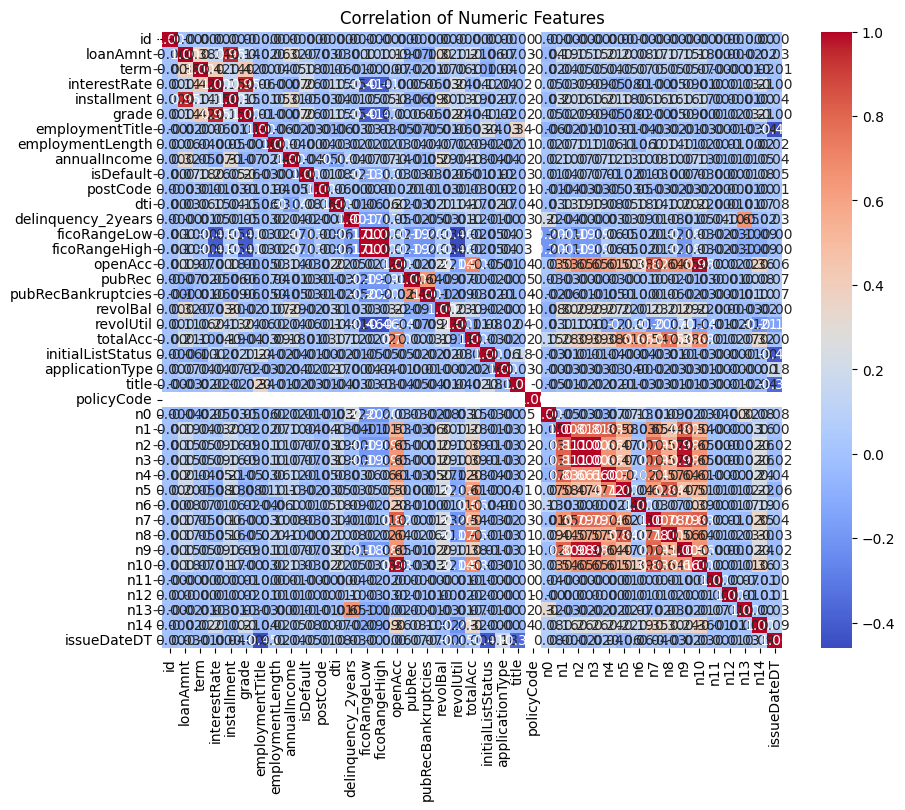

In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 定义要分析的数值特征
numeric_features = [t[0] for t in data_train1.dtypes if t[1] in ['int', 'double', 'float']]

# 使用VectorAssembler将所有数值型特征组合到一个向量中
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
assembled_data = assembler.transform(data_train1)

# 计算相关性矩阵
correlation_matrix = Correlation.corr(assembled_data, "features").head()[0]

# 将相关性矩阵转换为Pandas DataFrame
correlation_pd = pd.DataFrame(correlation_matrix.toArray())
correlation_pd.index = numeric_features
correlation_pd.columns = numeric_features

# 可视化
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_pd, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation of Numeric Features')
plt.show()
